## Data Description

- __cylinders__ -  multi-valued discrete
- __acceleration__ - continuous
- __displacement__ - continuous
- __model year__ - multi-valued discrete
- __horsepower__ - continuous
- __origin__ - multivalued discrete
- __weight__ - continous
- __car name__ - string (unique for each instance)
- __mpg__ - continous


K-means Clustering on the Car dataset to segment the cars into various categories

### Data Understanding & Exploration

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
car_name_df = pd.read_csv("data/car-name.csv")


In [3]:
car_name_df.head()


,car_name
0,chevrolet chevelle malibu
1,buick skylark 320
2,plymouth satellite
3,amc rebel sst
4,ford torino


In [4]:
car_name_df.shape


(398, 1)

In [5]:
car_attr_df = pd.read_json("data/car-attributes.json")


In [6]:
car_attr_df.head()


,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [7]:
car_attr_df.shape


(398, 8)

In [8]:
car_df = pd.concat([car_name_df, car_attr_df], axis="columns")


In [9]:
car_df.head()


,car_name,mpg,cyl,disp,hp,wt,acc,yr,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
1,buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
2,plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
3,amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
4,ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [10]:
car_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car_name  398 non-null    object 
 1   mpg       398 non-null    float64
 2   cyl       398 non-null    int64  
 3   disp      398 non-null    float64
 4   hp        398 non-null    object 
 5   wt        398 non-null    int64  
 6   acc       398 non-null    float64
 7   yr        398 non-null    int64  
 8   origin    398 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


**Observation** hp is of object type. Need to convert to numeric type

In [11]:
car_df.describe().T


,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


- For **mpg** Mean and median (50 %) are almost same, The data is symmetrically distributed around these values.

- On an average 5 cylinder are used. The weight distribution could be slightly right skewed since the mean is little higher than the median.

- The model year start from minimum of 70 and goes upto 82.

### Data Preparation & Analysis

In [12]:
car_df.isnull().sum()


car_name    0
mpg         0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
origin      0
dtype: int64

In [13]:
try:
    car_df["hp"] = car_df["hp"].astype(int)
except ValueError as ex:
    print(f"Error encoutered in type conversion - {ex}")


Error encoutered in type conversion - invalid literal for int() with base 10: '?'


In [14]:
len(car_df[car_df["hp"] == "?"])


6

In [15]:
car_df["hp"].replace("?", np.nan, inplace=True)

car_df.fillna(car_df.median(numeric_only=True), axis=0, inplace=True)


/var/folders/63/j6w_zsv155n1r5q96vf1qrwc0000gn/T/ipykernel_66974/1883343904.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_df["hp"].replace("?", np.nan, inplace=True)
/var/folders/63/j6w_zsv155n1r5q96vf1qrwc0000gn/T/ipykernel_66974/1883343904.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)

In [16]:
# class DfSimpleImputer(SimpleImputer):
#     def fit(self, X, y=None):
#         self.columns = X.columns
#         return super().fit(X, y)

#     def transform(self, X):
#         return pd.DataFrame(super().transform(X), columns=self.columns)


In [17]:
# si = DfSimpleImputer(missing_values=np.nan, strategy="median")
# si.fit(car_df.drop("car_name", axis=1))
# imputed_values = si.transform(car_df.drop("car_name", axis=1))
# car_df = pd.concat([car_df["car_name"], imputed_values], axis="columns")

In [18]:
len(car_df[car_df["hp"] == "?"])


0

In [19]:
car_df["hp"] = car_df["hp"].astype(int)


**Observation** There are no null values found in the DataFrame but '?' is found in **hp** column in 6 rows.

Using the median strategy to impute missing values can be more robust than using the mean, because the median is not as sensitive to outliers as the mean is.

However, these two methods do not take into account potential dependencies between columns.

In [20]:
any(car_df.duplicated())


False

**Observation** No duplicate vaules found

In [21]:
# Since origin is categorical it can be dropped

car_df.drop("origin", axis=1, inplace=True)


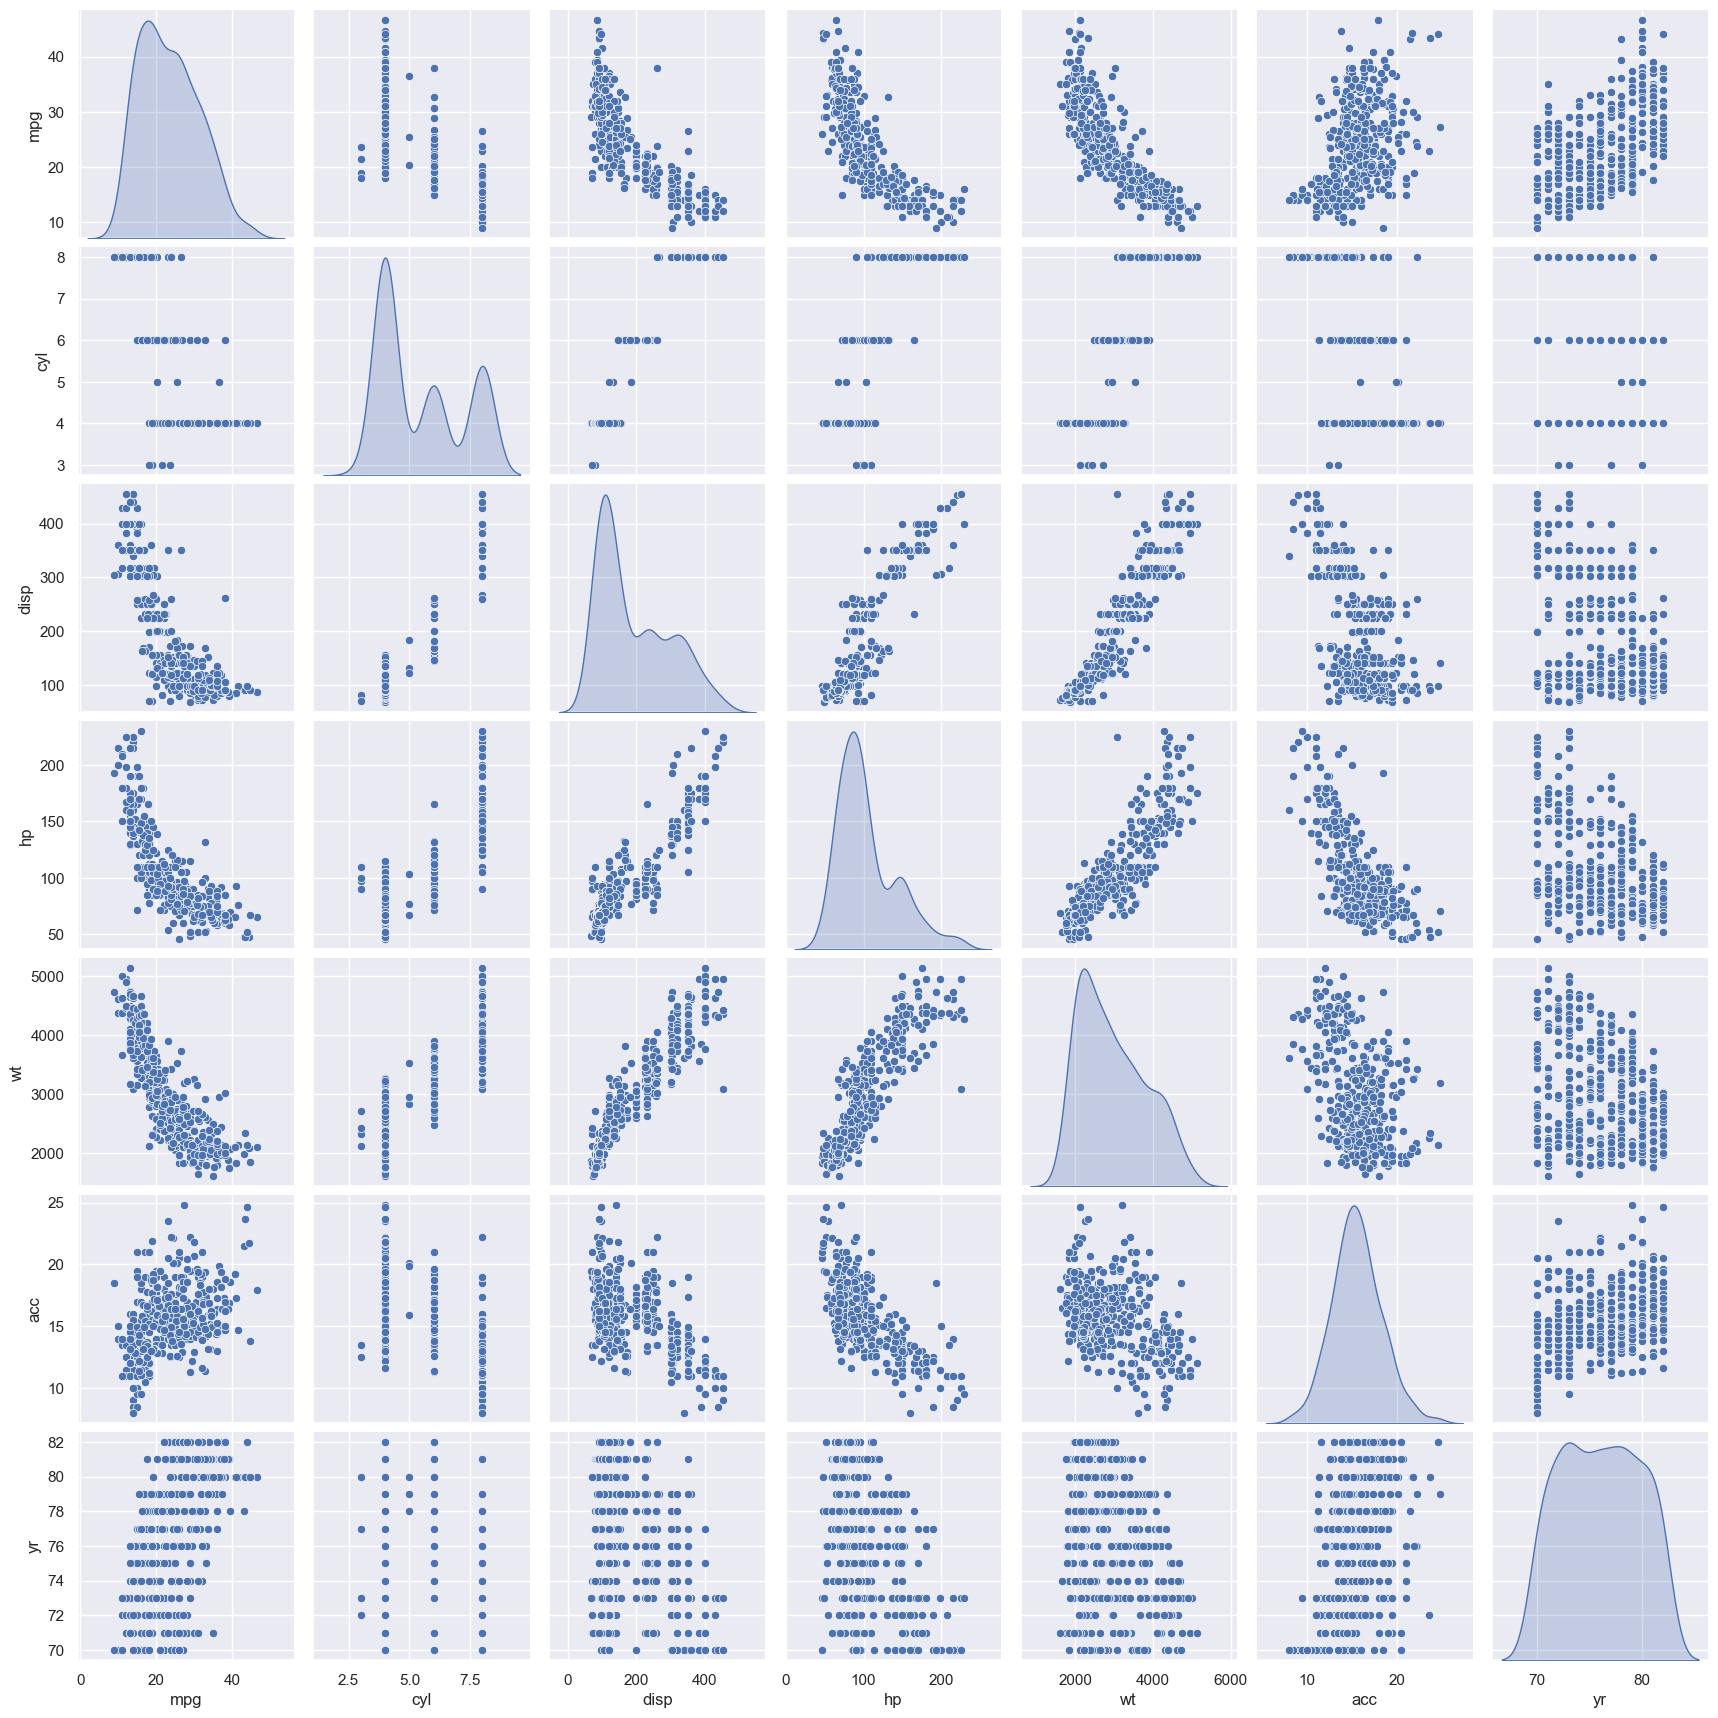

In [22]:
sns.pairplot(car_df, diag_kind="kde")


a scatterplot for 'wt' and 'disp'. Datapoints should be distinguishable by 'cyl'

<Axes: xlabel='wt', ylabel='disp'>

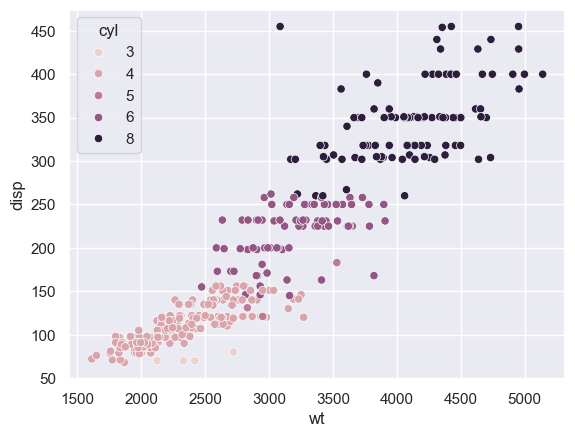

In [23]:
sns.scatterplot(data=car_df, x="wt", y="disp", hue="cyl")


It is observed that is a linear relationship with increase in weight the displacement of cylinder is also increasing and more number of cylinders are required

A scatterplot for 'wt' and 'mpg'. Datapoints should be distinguishable by 'cyl'. 

<Axes: xlabel='wt', ylabel='mpg'>

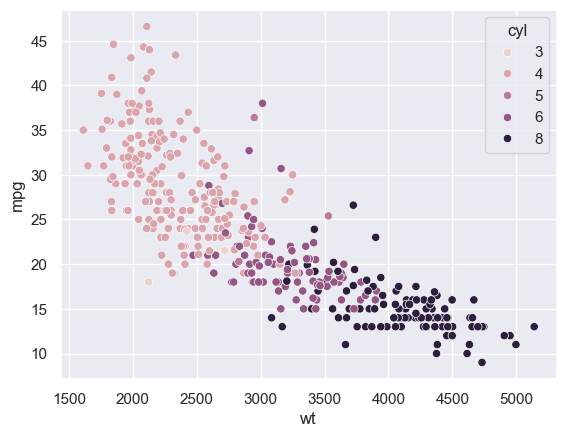

In [24]:
sns.scatterplot(data=car_df, x="wt", y="mpg", hue="cyl")


The observation is that more miles per gallon is there in cars with lesser weight

### Clustering

In [25]:
num_col = ["mpg", "cyl", "disp", "hp", "wt", "acc", "yr"]


In [26]:
clusters = []

X = car_df[num_col]
for k in range(2, 11):
    print(f"For k={k}")
    km = KMeans(n_clusters=k, n_init=10).fit(X)
    clusters.append(km.inertia_)
    print(km.inertia_)


For k=2
74289346.01128471
For k=3
34207980.76594871
For k=4
19051551.494178638
For k=5
13766068.792749476
For k=6
10294129.195279995
For k=7
7662667.066972291
For k=8
5661872.414507499
For k=9
4726681.563092025
For k=10
4015526.688313188


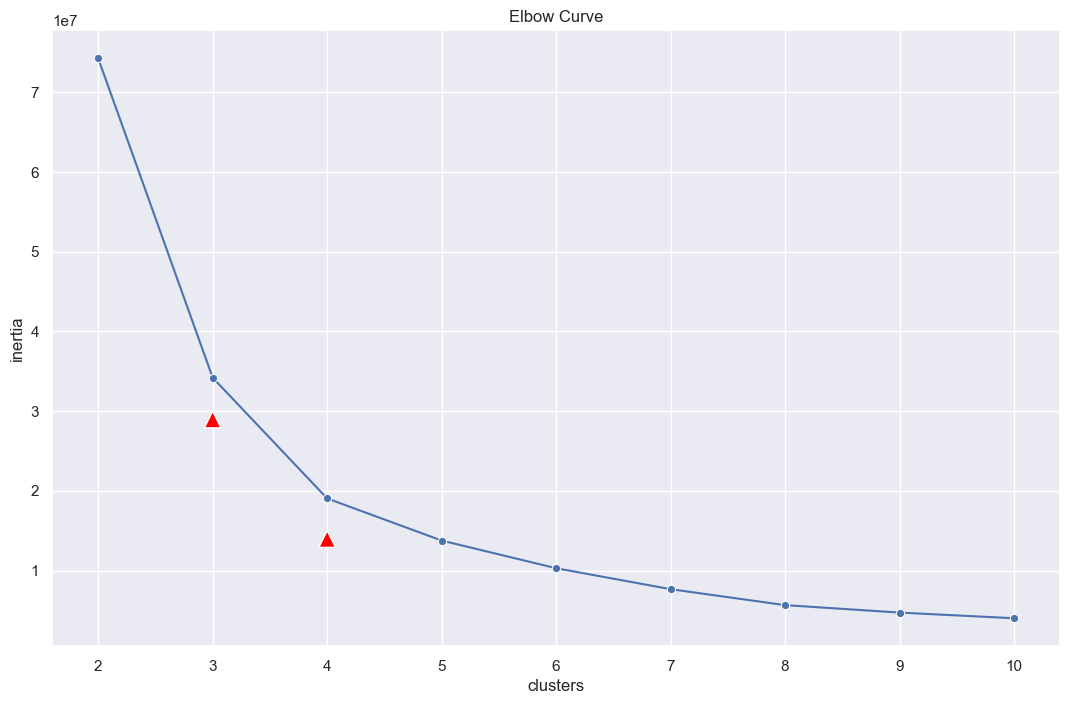

In [27]:
fig, ax = plt.subplots(figsize=(13, 8))

arrowprops = {"facecolor": "red"}

plt.annotate(" ", xy=(4, 15000000), arrowprops=arrowprops)
plt.annotate(" ", xy=(3, 30000000), arrowprops=arrowprops)
sns.lineplot(x=list(range(2, 11)), y=clusters, ax=ax, marker="o")
ax.set_title("Elbow Curve")
ax.set_xlabel("clusters")
ax.set_ylabel("inertia")


plt.show()


Appropriate possible elbow points 3, 4 in X-axis highlighted

When choosing a normalization/standardization method for k-means clustering, generally it a good to start with z-score normalization. 

This is because it is a widely used and well-established method that is easy to implement and can be effective for many datasets.

In [28]:
X = X.apply(zscore)


In [29]:
sil_score = []
for n_clusters in [3, 4]:
    clusterer = KMeans(n_clusters=n_clusters, n_init=10)
    preds = clusterer.fit_predict(X)
    score = silhouette_score(X, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, the silhouette score is 0.3531671663867806)
For n_clusters = 4, the silhouette score is 0.3482906124053297)


**Observation** The Silhouette score for *n_clusters=3* is higher than one with 4

In [30]:
model = KMeans(3, n_init=10, random_state=42) # setting explicit default value of n_init=10
model.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [31]:
prediction = model.predict(X)
car_df["group"] = prediction


In [32]:
car_df.sample(5, random_state=42)

,car_name,mpg,cyl,disp,hp,wt,acc,yr,group
198,honda civic,33.0,4,91.0,53,1795,17.4,76,0
396,ford ranger,28.0,4,120.0,79,2625,18.6,82,0
33,amc gremlin,19.0,6,232.0,100,2634,13.0,71,2
208,plymouth volare premier v8,13.0,8,318.0,150,3940,13.2,76,1
93,plymouth fury gran sedan,14.0,8,318.0,150,4237,14.5,73,1


In [33]:
car_df["group"].unique()


array([1, 0, 2], dtype=int32)

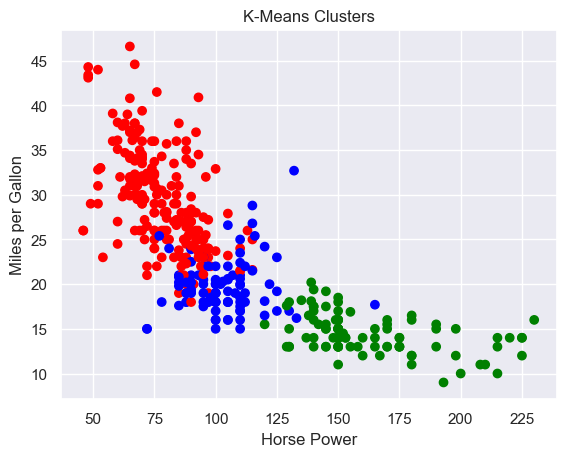

In [34]:
X = car_df[["hp", "mpg"]].values

# Specify the colors for the clusters
colors = ["red", "green", "blue"]

plt.scatter(X[:, 0], X[:, 1], c=[colors[label] for label in prediction])

plt.title("K-Means Clusters")
plt.xlabel("Horse Power")
plt.ylabel("Miles per Gallon")
plt.show()


Predict which cluster a datapoint belongs to.

In [35]:
# In the same order as (mpg, cyl, disp, hp, wt, acc, yr, origin)
data = [15, 7, 380, 172, 3500, 10, 70]
label = model.predict(
    [
        data,
    ]
)
label


/Users/neelabalan/code/notebooks/sklearn-workbench/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([1], dtype=int32)

## Data Description

The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. 

This particular combination of vehicles was  chosen  with  the  expectation  that  the  bus,  van  and  either  one  of  the  cars  would  be  readily  distinguishable,  but  it  would  be  more  difficult to distinguish between the cars.

All the features are numeric i.e. geometric features extracted from the silhouette

### Data Understanding & Cleaning

In [36]:
vehicle = pd.read_csv("data/vehicle.csv")


In [37]:
vehicle.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [38]:
vehicle.shape

(846, 19)

In [39]:
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [40]:
vehicle.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [41]:
vehicle[vehicle.isna().any(axis=1)].head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,NaN,106.0,172.0,50.0,6,255.0,26.0,28.0,169,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
9,93,44.0,98.0,NaN,62.0,11,183.0,36.0,22.0,146,202.0,505.0,152.0,64.0,4.0,14.0,195.0,204,car
19,101,56.0,100.0,215.0,NaN,10,208.0,32.0,24.0,169,227.0,651.0,223.0,74.0,6.0,5.0,186.0,193,car
35,100,46.0,NaN,172.0,67.0,9,157.0,43.0,20.0,150,170.0,363.0,184.0,67.0,17.0,7.0,192.0,200,van
66,81,43.0,68.0,125.0,57.0,8,149.0,46.0,19.0,146,169.0,323.0,172.0,NaN,NaN,18.0,179.0,184,bus


In [42]:
vehicle.fillna(vehicle.median(numeric_only=True), axis=0, inplace=True)

In [43]:
vehicle.isnull().sum()


compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

In [44]:
vehicle.describe().T

,count,mean,std,min,25%,50%,75%,max
compactness,846.0,93.678487,8.234474,73.0,87.00,93.0,100.00,119.0
circularity,846.0,44.823877,6.134272,33.0,40.00,44.0,49.00,59.0
distance_circularity,846.0,82.100473,15.741569,40.0,70.00,80.0,98.00,112.0
radius_ratio,846.0,168.874704,33.401356,104.0,141.00,167.0,195.00,333.0
pr.axis_aspect_ratio,846.0,61.677305,7.882188,47.0,57.00,61.0,65.00,138.0
max.length_aspect_ratio,846.0,8.567376,4.601217,2.0,7.00,8.0,10.00,55.0
scatter_ratio,846.0,168.887707,33.197710,112.0,147.00,157.0,198.00,265.0
elongatedness,846.0,40.936170,7.811882,26.0,33.00,43.0,46.00,61.0
pr.axis_rectangularity,846.0,20.580378,2.588558,17.0,19.00,20.0,23.00,29.0
max.length_rectangularity,846.0,147.998818,14.515652,118.0,137.00,146.0,159.00,188.0


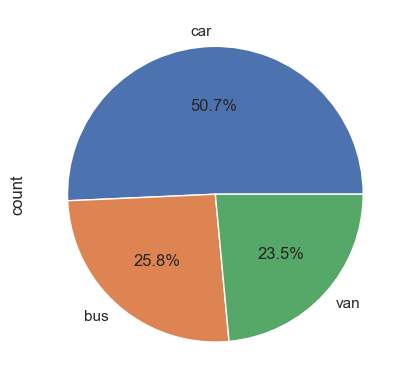

In [45]:
vehicle["class"].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

**Observation** Almost 50.7% of the cases are car

In [46]:
any(vehicle.duplicated())


False

**Observation** There aren't any duplicate values in the _vehicle_ DataFrame

### Data Preparation

In [47]:
cat_mapp = pd.DataFrame({'class': vehicle['class'], 'code': vehicle['class'].astype('category').cat.codes})
cat_mapp.sample(5)

,class,code
819,car,1
215,car,1
437,car,1
577,car,1
227,van,2


**Observation** 

| type | code |
| :--- | :--- |
| bus  | 0    |
| car  | 1    |
| van  | 2    |

In [48]:
# Encode the class
vehicle["class"] = vehicle["class"].astype("category")
vehicle["class"] = vehicle["class"].cat.codes

vehicle["class"].unique()


array([2, 1, 0], dtype=int8)

In [49]:
# Tranform X and Y and standarize before splitting them

scaler = StandardScaler()
num_col = [column for column in vehicle.columns if not column == "class"]
subset = scaler.fit_transform(vehicle[num_col].copy())


In [50]:
scaled_df = pd.DataFrame(subset, columns=num_col)
scaled_df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,0.160580,0.518073,0.057177,0.273363,1.310398,0.311542,-0.207598,0.136262,-0.224342,0.758332,-0.401920,-0.341934,0.285705,-0.327326,-0.073812,0.380870,-0.312012,0.183957
1,-0.325470,-0.623732,0.120741,-0.835032,-0.593753,0.094079,-0.599423,0.520519,-0.610886,-0.344578,-0.593357,-0.619724,-0.513630,-0.059384,0.538390,0.156798,0.013265,0.452977
2,1.254193,0.844303,1.519141,1.202018,0.548738,0.311542,1.148719,-1.144597,0.935290,0.689401,1.097671,1.109379,1.392477,0.074587,1.558727,-0.403383,-0.149374,0.049447
3,-0.082445,-0.623732,-0.006386,-0.295813,0.167907,0.094079,-0.750125,0.648605,-0.610886,-0.344578,-0.912419,-0.738777,-1.466683,-1.265121,-0.073812,-0.291347,1.639649,1.529056
4,-1.054545,-0.134387,-0.769150,1.082192,5.245643,9.444962,-0.599423,0.520519,-0.610886,-0.275646,1.671982,-0.648070,0.408680,7.309005,0.538390,-0.179311,-1.450481,-1.699181


In [51]:
y = vehicle["class"]
X = scaled_df.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Model Building

In [52]:
from sklearn.svm import SVC

base_model = SVC(gamma="auto")
base_model.fit(X_train, y_train)
base_model.score(X_test, y_test)


0.9705882352941176

In [53]:
from sklearn.metrics import classification_report

y_pred = base_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        44
           1       0.99      0.95      0.97        86
           2       0.93      0.97      0.95        40

    accuracy                           0.97       170
   macro avg       0.96      0.98      0.97       170
weighted avg       0.97      0.97      0.97       170



PCA on the data with 10 components

In [54]:
pca = PCA(n_components=10)
pca.fit(X)


PCA(n_components=10)

Visualizing Cumulative Variance Explained with Number of Components

In [55]:
pca.explained_variance_ratio_

array([0.52186034, 0.16729768, 0.10562639, 0.0654746 , 0.05089869,
       0.02996413, 0.01991366, 0.01231501, 0.00891215, 0.00509715])

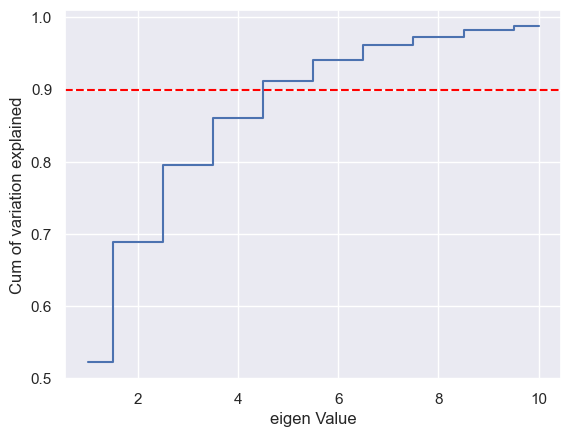

In [56]:
plt.step(list(range(1, 11)), np.cumsum(pca.explained_variance_ratio_), where="mid")
plt.ylabel("Cum of variation explained")
plt.xlabel("eigen Value")
plt.axhline(0.90, linestyle='--', color='red')
plt.show()

In [57]:
# With 6 variables we can explain over 90% of the variation in the original data

pca_new = PCA(n_components=6)
pca_new.fit(X)

PCA(n_components=6)

In [58]:
X_pca = pca_new.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)
model = SVC(gamma="auto")
model .fit(X_train, y_train)
model.score(X_test, y_test)

0.9294117647058824

In [59]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.92      0.94      0.93        86
           2       0.92      0.88      0.90        40

    accuracy                           0.93       170
   macro avg       0.93      0.92      0.93       170
weighted avg       0.93      0.93      0.93       170



**Observation**
- The average value of precision and recall scores are quite good. The model performs well in not making false positive predictions and equally good at finding all the positive instances.
- The precision, recall and f1-score are slightly better in the case of predicting the 'bus' category which maps to 0.

### Performance Improvement

In [60]:
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [1, 10, 100], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf']}

# param_distributions = {'C': uniform(0, 5), 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf']}

svm = SVC()
random_search = GridSearchCV(svm, param_grid, cv=5)

random_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']})

In [61]:
best_params = random_search.best_params_
print(f"Best parameters observed - {best_params}")

svm_best = SVC(**best_params)
svm_best.fit(X_train, y_train)
svm_best.score(X_test, y_test)

Best parameters observed - {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


0.9352941176470588

In [62]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.92      0.94      0.93        86
           2       0.92      0.88      0.90        40

    accuracy                           0.93       170
   macro avg       0.93      0.92      0.93       170
weighted avg       0.93      0.93      0.93       170



**Observations**

- The base model with 10 features has better performance compared to the one trained on PCA
- Post tuning the mean-accuracy has slightly improved (1%) on 6-features from PCA.

### Data Understanding & Cleaning

- The data should be linearly correlated.

- PCA is sensitive to the scale of the data, so it is usually a good idea to standardize the data by subtracting the mean and dividing by the standard deviation before applying PCA.

- PCA is based on the assumption that the provided data is continuous and has a normal distribution. If not suitable transformation has be done prior to applying PCA.

- The variance of the data is the same across all dimensions.

- Advantages

  	- It can improve the interpretability and visualization of the data by reducing the number of dimensions.

	- It can be used to identify patterns and relationships in the data that may not be apparent in the original dataset.

- Disadvantages

	- The assumption that the data is continuous and normally distributed might not be case always.

	- It can be sensitive to outliers